## All the necessary imports ##

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline
import matplotlib.cm as cm
import copy
import tempfile
import os

## 1.1 Feature Decomposition - PCA ##

PCA performs an orthogonal transformation of the observation matrix, outputting a set of linear uncorrelated variables called Princial Components. Each PC is orthonormal to the others. The first PC has the largest possible variance of the input dataset, the second PC is orthogonal to the first PC and contains the largest possible variance of the residual signal and so on.

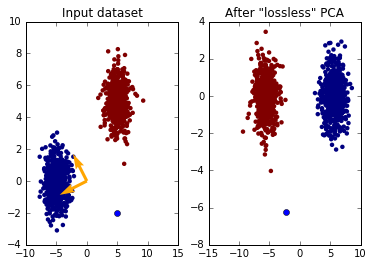

In [2]:
'''
Example to show effect of PCA.
Creating a dummy dataset comprising of 2 blobs, one centered at (-5, 0), other at (5, 5).
'''
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA

# Creating dummy dataset comprising of two blobs
X, y = make_blobs(n_samples=1000, 
                  random_state=101, 
                  centers=[[-5, 0], [5, 5]])

# PCA object with 2 PCs
pca = PCA(n_components=2)

# Fit PCA object on the data
X_pca = pca.fit_transform(X)
pca_comp = pca.components_.T

test_point = np.matrix([5, -2])
test_point_pca = pca.transform(test_point)

# First plot for input dataset
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], 
            X[:, 1], 
            c=y, 
            edgecolors='none')
plt.quiver(0, 
           0, 
           pca_comp[:,0], 
           pca_comp[:,1], 
           width=0.02, 
           scale=5, 
           color='orange')
plt.plot(test_point[0, 0], test_point[0, 1], 'o')
plt.title('Input dataset')

# 2nd plot using the X_pca fitted object
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], # first feature
            X_pca[:, 1], # second feature
            c = y, # color by classification type
            edgecolors='none')
plt.plot(test_point_pca[0, 0], 
         test_point_pca[0, 1], 
         'o')
plt.title('After "lossless" PCA')

plt.show()

## 1.2 Testing the PCA result ##

The blue point in the input dataset is in (5,-2). After PCA, it is in (-2.3, -6.2)

In [4]:
print "The blue point is in", test_point[0, :]
print "After the transformation is in", test_point_pca[0, :]

# Dot product
print "Since (X-MEAN) * PCA_MATRIX = ", np.dot(test_point - pca.mean_, pca_comp)

The blue point is in [[ 5 -2]]
After the transformation is in [-2.34969911 -6.2575445 ]
Since (X-MEAN) * PCA_MATRIX =  [[-2.34969911 -6.2575445 ]]


## 2.1 SVD: Singular Value Decomposition ##

SVD decomposes a matrix(M) into 3 matrices whose multiplication gives back M.

If M is of structure (m * n)

* U: Left singular vectors(m * m)
* E: Singular values (m * n)
* W: Right singular vectors (n* n)

The diagonal of E contains the variance explained by the PCs.


## 2.2 Testing PCA-SVD on the Iris dataset ##

The Iris dataset has 4 features. We will extract the top 2 features and check the sum of the variance explained by them.

Iris dataset contains 4 features
After PCA, it contains 2 features
The variance is [% of original]: 0.977631775025


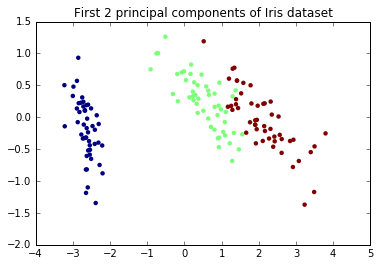

In [7]:
from sklearn import datasets

# Load dataset 
iris = datasets.load_iris()

'''
Attribute Information:

1. sepal length in cm 
2. sepal width in cm 
3. petal length in cm 
4. petal width in cm 
5. class: 
-- Iris Setosa 
-- Iris Versicolour 
-- Iris Virginica
'''

# Define features and target variabel
X = iris.data
y = iris.target

print "Iris dataset contains", X.shape[1], "features"

# Get top 2 features
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

print "After PCA, it contains", X_pca.shape[1], "features"

# Get variance explained by top 2 features obtained using explained_variance_ratio_
print "The variance is [% of original]:", sum(pca.explained_variance_ratio_)

# Plot 
plt.scatter(X_pca[:, 0], # first feature
            X_pca[:, 1], # second feature
            c = y, # color by classification type
            edgecolors = 'none')
plt.title('First 2 principal components of Iris dataset')

plt.show()

## 2.3 Checking performance of PCA classifier compared to classification made with all 4 features. ##

In [8]:
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

# Define Stochastic gradient descent classifier
def test_classification_accuracy(X_in, y_in):
    X_train, X_test, y_train, y_test = \
        train_test_split(X_in, 
                         y_in, 
                         random_state=101, 
                         train_size=0.50)

    clf = SGDClassifier('log', 
                        random_state=101)
    clf.fit(X_train, y_train)
    # Accuracy score on the test set
    return accuracy_score(y_test, clf.predict(X_test))

# Accuracy on the full feature set
print "SGDClassifier accuracy on Iris set:", \
            test_classification_accuracy(X, y)
    
# Accuracy on the PCA 2 features
print "SGDClassifier accuracy on Iris set after PCA (2 components):", \
            test_classification_accuracy(X_pca, y)

SGDClassifier accuracy on Iris set: 0.586666666667
SGDClassifier accuracy on Iris set after PCA (2 components): 0.72


We get a higher accuracy performance using the 2 feaures.

## 2.4 Checking scalability of PCA-SVD ##

SVD(the core of PCA) is not stochastic, it needs the entire matrix to extract PCs.

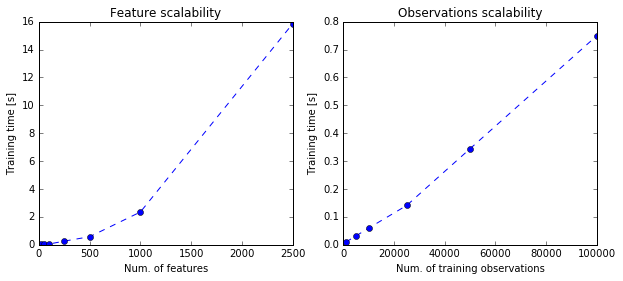

In [9]:
'''
Create matrices with 10,000 points and 20,50,100,250,1000,2500 features to be processed by PCA. 
'''
import time

def check_scalability(test_pca):
    pylab.rcParams['figure.figsize'] = (10, 4)
    
    # Checking feature scalability keeping number of observations at 10,000
    n_points = 10000
    n_features = [20, 50, 100, 250, 500, 1000, 2500]
    # Keep track of time for each case
    time_results = []

    for n_feature in n_features:
        X, _ = make_blobs(n_points, 
                          n_features = n_feature, 
                          random_state=101)
        
        pca = copy.deepcopy(test_pca)
        tik = time.time()
        pca.fit(X)
        time_results.append(time.time()-tik)
    
    plt.subplot(1, 2, 1)
    plt.plot(n_features, 
             time_results, 
             'o--')
    plt.title('Feature scalability')
    plt.xlabel('Num. of features')
    plt.ylabel('Training time [s]')
    
    # Checking observations scalability keeping number of features at 100
    n_observations = [1000, 5000, 10000, 25000, 50000, 100000]
    n_features = 100
    # Keep track of time for each case.
    time_results = []

    for n_points in n_observations:
        X, _ = make_blobs(n_points, 
                          n_features = n_features, 
                          random_state=101)
        pca = copy.deepcopy(test_pca)
        tik = time.time()
        pca.fit(X)
        time_results.append(time.time()-tik)

    plt.subplot(1, 2, 2)
    plt.plot(n_observations, 
             time_results, 
             'o--')
    plt.title('Observations scalability')
    plt.xlabel('Num. of training observations')
    plt.ylabel('Training time [s]')
    
    
    
    plt.show()
    
check_scalability(PCA(None))

Clearly, PCA based on Singular Value Decomposition is not scalable.

## 3: PCA based on Randomized SVD or Randomized PCA ##

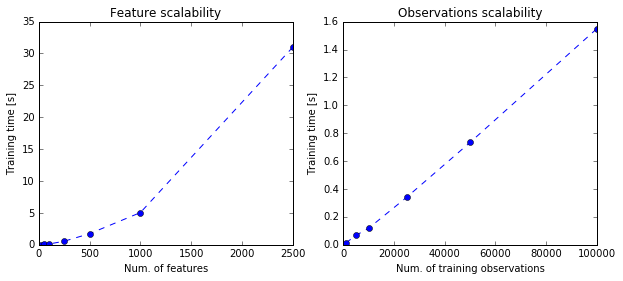

In [10]:
'''
Checking scalability using a full or lossless decomposition with Randomized PCA
'''
from sklearn.decomposition import RandomizedPCA

check_scalability(RandomizedPCA(None))

Randomized PCA performs worse than PCA-SVD when performing lossless decomposition of features.

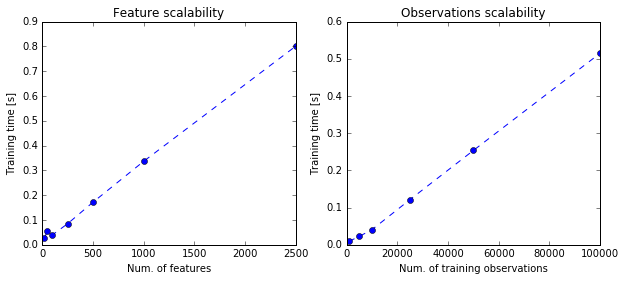

In [11]:
'''
Checking scalability using a decomposition to 20 features with Randomized PCA
'''
check_scalability(RandomizedPCA(20))

Randomized PCA performs much faster than PCA-SVD with a decomposition to 20 features.

Drawback of Randomized PCA:

* The training dataset in its entirety must fit in-memory in order to be decomposed.

## 4: Incremental/Mini-Batch PCA ##

Its algorithm is as follows:

* The batch of the data is split into mini batches with the same number of observations in each(the number of observations in each mini batch should be greater than the number features).

* Then the first mini batch is centered and its SVD decomposition is performed, storing the PCs.

* The next mini batch enters the process, is centered, and stacked with the PCs obtained from the previous mini batch, in other words, the PCs are inserted as additional observations.

* Another SVD is performed and the PCs are overwritten with new ones.

* This goes on till the last mini batch, for each of them there is the centering, the stacking, and finally the SVD.

We are performing many small PCA-SVD operations on the mini batches.

In [12]:
'''
Checking Incremental PCA on 10 million observations and 100 features.
'''

from sklearn.decomposition import IncrementalPCA

X, _ = make_blobs(100000, 
                  n_features=100, 
                  random_state=101)

# Each mini batch is 1000
pca = IncrementalPCA(None, batch_size=1000)

tik = time.time()

# Fit the data
for i in range(100):
    pca.partial_fit(X)
print "PCA on 10M points run with constant memory usage in ", time.time() - tik, "seconds"

PCA on 10M points run with constant memory usage in  76.5698139668 seconds


## 5: Sparse PCA ##

Sparse PCA is useful when we have >1000 features. Instead of operating feature reduction using SVD on the covariance matrix, it operates a feature selection-like operation on the matrix finding a set of sparse components that best reconstruct the data.

In [13]:
'''
Checking performance of Sparse PCA on 25,000 observations and 10,000 features.
'''
from sklearn.decomposition import MiniBatchSparsePCA

X, _ = make_blobs(25000, 
                  n_features=10000, 
                  random_state=101)

tik = time.time()
pca = MiniBatchSparsePCA(20, 
                         method='cd', 
                         random_state=101, 
                         n_iter=1000)
pca.fit(X)
print "SparsePCA on matrix", X.shape, "done in ", time.time() - tik, "seconds"

/Users/adarshnair/graphlab/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


SparsePCA on matrix (25000, 10000) done in  57.6773340702 seconds
